# Distribution Similarity

You may want to test the stability of a feature in your model over time.

Does the feature data from 2016-2018 that you used to train your model still describe your latest data from 2019, or has the feature population changed, requiring you to update your model?

With `probatus.stat_tests` you can use different statistical tests to evaluate if 

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import pytest
import probatus
from probatus.binning import AgglomerativeBucketer, SimpleBucketer, QuantileBucketer
from probatus.stat_tests import psi

Define some test distributions

In [2]:
counts = 1000
d_normal = np.random.normal(size=counts)
d_normaltoo = np.random.normal(size=counts)
d_normalshift = np.random.normal(loc=0.15, size=counts)
d_t = np.random.standard_t(df=10, size=counts)
d_lorentz = np.random.standard_cauchy(size=counts)
d_lorentz = d_lorentz[(d_lorentz > -25) & (d_lorentz < 25)]
d_cauchy = stats.cauchy.rvs(loc=0, scale=5, size=counts)
d_cauchy = d_cauchy[(d_cauchy > -10) & (d_cauchy < 10)]
d_weibull = np.random.weibull(1, size=counts) - 0.5

Select d1 and d2

In [3]:
d1 = d_normal
d2 = d_normalshift

Visualize

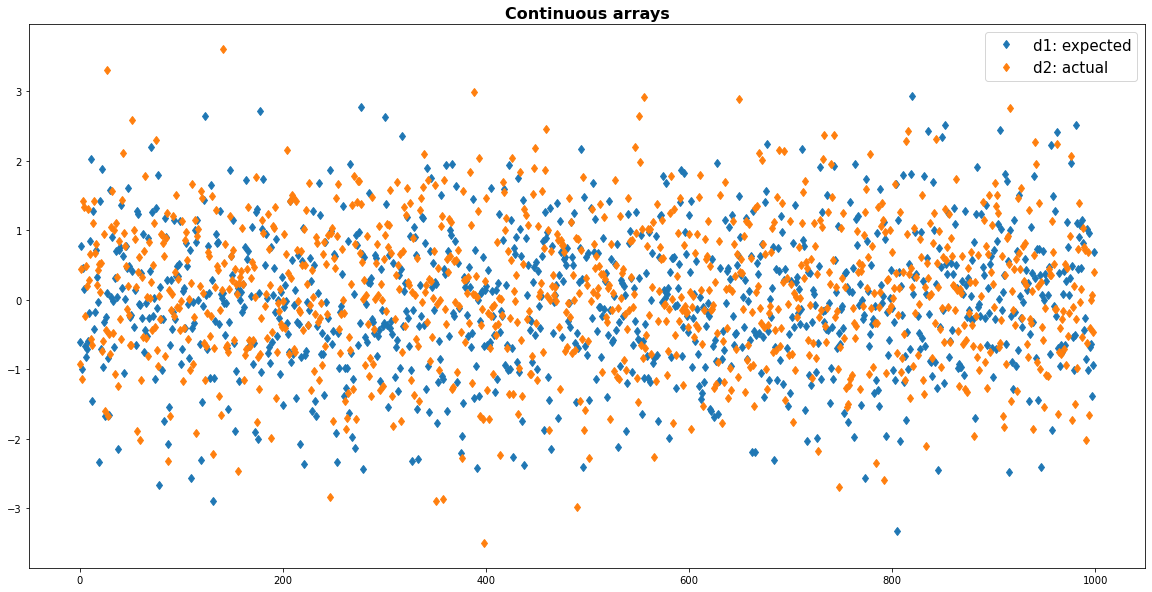

In [4]:
plt.figure(figsize=(20,10))
plt.plot(d1, 'd', label='d1: expected')
plt.plot(d2, 'd', label='d2: actual')
plt.legend(fontsize = 15)
plt.title('Continuous arrays', fontsize=16, fontweight='bold')
plt.show()

#### Binning - QuantileBucketer

In [16]:
bins = 10
myBucketer = probatus.binning.QuantileBucketer(bins)
myBucketer.fit(d1)
d1_bincounts_, d1_boundaries_ = probatus.binning.QuantileBucketer(bins).quantile_bins(d1, bins, inf_edges=True)
d1_bincounts = myBucketer.fit_compute(d1)
d2_bincounts = myBucketer.compute(d2)

print("Number of bins:")
print(len(d1_bincounts_), end="\n\n")

print("Bincounts for d1 and d2:")
print(d1_bincounts)
print(d2_bincounts, end="\n\n")

print("Boundaries for bins:")
print(d1_boundaries_)

Number of bins:
10

Bincounts for d1 and d2:
[100 100 100 100 100 100 100 100 100 100]
[ 89  82  94  73  99 117  89 111 117 126]

Boundaries for bins:
[       -inf -1.28133113 -0.82508058 -0.52082463 -0.26712699 -0.02524618
  0.23075993  0.49024574  0.81351769  1.25290906         inf]


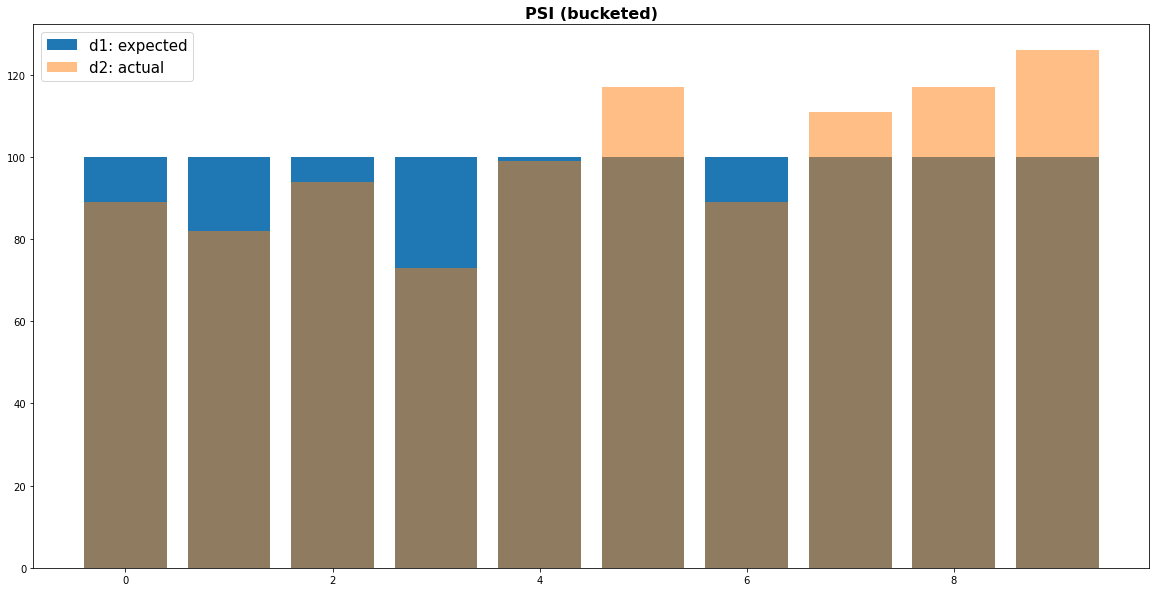

In [6]:
plt.figure(figsize=(20,10))
plt.bar(range(0, len(d1_bincounts)), d1_bincounts, label='d1: expected')
plt.bar(range(0, len(d2_bincounts)), d2_bincounts, label='d2: actual', alpha=0.5)
plt.title('PSI (bucketed)', fontsize=16, fontweight='bold')
plt.legend(fontsize=15)
plt.show()

## PSI

Advantages:
* Industry (banking / risk modeling) standard

Disadvantages:
* Requires discrete distribution.
* Strong dependence on number of bins. More bins -> higher PSI
* Not very sensitive to extrema bins.
* Does not return p-value.
* Test statistic (TS; in this case, the PSI value) is difficult to interpret, i.e. to define critical values that indicate action required or not.

10-20 bins are typically used

In [7]:
psivalue = probatus.stat_tests.psi(d1_bincounts, d2_bincounts, verbose=True)


PSI = 0.027541367452472675

PSI: Critical values defined according to de facto industry standard:
PSI <= 0.10: No significant distribution change.

PSI: Critical values defined according to Yurdakul (2018):
Distributions similar.


### Smarter PSI
As seen above, probatus evaluates the null hypothesis according to Yurdakul (2018), this is done because:
* Industry-standard PSI critical values of 0.1 and 0.25 are unreliable heuristics because there is a strong dependency on sample sizes and number of bins.
* Aside from these heuristics, the PSI value is not easily interpretable in the context of common statistical frameworks (like a p-value or confidence levels).

[Yurdakul 2018](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations) calculate the expectation and variance of PSI, in terms of sample sizes and number of bins, and based on a normal approximation, which allows a practical test to be defined with critical values determined by standard probability percentiles (or z-scores).

In [8]:
n = len(d1)
m = len(d2)
b = bins
alpha = [0.95, 0.99, 0.999]
z_alpha = stats.norm.ppf(alpha)

In [9]:
PSI_critvals = ((1 / n) + (1 / m)) * (b - 1) + z_alpha * ((1 / n) + (1 / m)) * np.sqrt(2 * (b - 1))
PSI_critvals

array([0.03195705, 0.03773972, 0.04422149])

## KS: Kolmogorov-Smirnov
The Kolmogorov-Smirnov test compares two distributions by calculating the maximum difference of the two samples' distribution functions, as illustrated by the black arrow in the following figure:

<img align="middle" src="KS2_Example.png" alt="Example of the Kolmogorov-Smirnov value" width="400" height="400">

Advantages:
* Sensitive to differences in both location and shape of the empirical cumulative distribution functions of the two samples.

Disadvantages:
* Only works for continuous distributions (unless modified, e.g. see [Jeng 2006](https://bmcmedresmethodol.biomedcentral.com/track/pdf/10.1186/1471-2288-6-45)).
* In large samples, small and unimportant differences can be statistically significant ([Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)).
* In small samples, large and important differences can be statistically insignificant ([Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)).

In [17]:
ks, pvalue = probatus.stat_tests.ks(d1_bincounts, d2_bincounts, verbose=True)


KS: pvalue = 0.05244755244755244

KS: Null hypothesis cannot be rejected. Distributions not statistically different.


### PAI: Population Accuracy Index

[Taplin & Hunt 2019](https://www.mdpi.com/2227-9091/7/2/53/pdf)

Advantages:
* Goes beyond testing just distribution similarity but actually measuring impact of feature changes on variance of model output.

Disadvantages:
* Bleeding-edge academic paper
* Implementation only exists for linear/multiple regression.

Conclusion:
* Implementing for tree-based models cumbersome (would require re-testing model multiple times).
* As a result, value to probatus limited. Very low priority.

## ES: Epps-Singleton

KS relies on the empirical distribution function, whereas ES is based on the empircal _characteristic_ function ([Epps & Singleton 1986](https://www.sci-hub.tw/10.1080/00949658608810963), [Goerg & Kaiser 2009](https://sci-hub.tw/10.1177/1536867X0900900307)).

Advantages:
* Unlike the KS, the ES can be used on both continuous & discrete distributions.
* ES has higher power (vs KS) in many examples.

Disadvantages:
* Not recommended for fewer than 25 observations. Instead, use the AD TS. (However, ES can still be used for small samples. A correction factor is applied so that the asymptotic TS distribution more closely follows the chi-squared distribution, such that p-values can be computed.)

In [11]:
es, pvalue = probatus.stat_tests.es(d1_bincounts, d2_bincounts, verbose=True)


ES: pvalue = 1.060060495894979e-24

ES: Null hypothesis rejected with 99% confidence. Distributions very different.


## AD: Anderson-Darling

Anderson & Darling 1954

The critical values depend on the number of samples.

Works on both continuous and discrete distributions.

The critical values corresponding to the significance levels from 0.01 to 0.25 are taken from [1].

p-values are floored / capped at 0.1% / 25%. Since the range of critical values might be extended in future releases, it is recommended not to test p == 0.25, but rather p >= 0.25 (analogously for the lower bound).

In [12]:
ad, pvalue = probatus.stat_tests.ad(d1_bincounts, d2_bincounts, verbose=True)
#ad, pvalue = probatus.stat_tests.ad(d1, d2, verbose = True)


AD: pvalue = 0.08311329742294998

AD: Null hypothesis cannot be rejected. Distributions not statistically different.


#### Distribution statistics 

`DistributionStatistics` is a wrapper class that applies a statistical method and a binning strategy to data in one go:

In [13]:
from probatus.stat_tests import DistributionStatistics

In [14]:
myDist = DistributionStatistics(statistical_test='PSI', binning_strategy='quantilebucketer', bin_count=10)
myDist.fit(d1, d2)
myDist

AttributeError: 'DistributionStatistics' object has no attribute 'fit'

In [ ]:
myDist = DistributionStatistics(statistical_test='ES', binning_strategy='quantilebucketer', bin_count=10)
myDist.fit(d1, d2)
myDist

In [ ]:
myDist = DistributionStatistics(statistical_test='KS', binning_strategy='quantilebucketer', bin_count=10)
myDist.fit(d1, d2)
myDist

#### AutoDist

The `AutoDist` is a class to automatically apply all implemented statistical distribution tests and binning strategies to (a selection of) features in two dataframes:

In [ ]:
from probatus.stat_tests import AutoDist
from probatus.datasets import lending_club

In [ ]:
credit_df, X_train, X_test, y_train, y_test = lending_club()

In [ ]:
features = X_train.columns.values.tolist()

In [ ]:
myAutoDist = AutoDist(statistical_tests='all', binning_strategies='all', bin_count=10)

In [ ]:
myAutoDist.fit(X_train, X_test, column_selection=features, return_failed_tests=False, suppress_warnings=True)